In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#set the random seed
np.random.seed(0)
torch.manual_seed(0)

In [3]:
#set seaborn style
%matplotlib inline
sns.set_style('darkgrid')

In [4]:
#define the path for our data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "D:/Dataset-pytorch/seefood/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => D:/Dataset-pytorch/seefood/


In [5]:
#Let’s define a dictionary to hold the image transformations for train/test sets. We will resize all images to have size (224, 224) as well as convert the images to tensor.
#The ToTensor operation in PyTorch convert all tensors to lie between (0, 1).
#ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [11]:
hotdog_dataset = datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]
                                     )
hotdog_dataset

Dataset ImageFolder
    Number of datapoints: 498
    Root location: D:/Dataset-pytorch/seefood/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [12]:
#The class_to_idx function is pre-built in PyTorch. It returns class ID's present in the dataset.
hotdog_dataset.class_to_idx

{'hot_dog': 0, 'not_hot_dog': 1}

In [13]:
#We will now construct a reverse of this dictionary; a mapping of ID to class.
idx2class = {v: k for k, v in hotdog_dataset.class_to_idx.items()}
idx2class

{0: 'hot_dog', 1: 'not_hot_dog'}

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

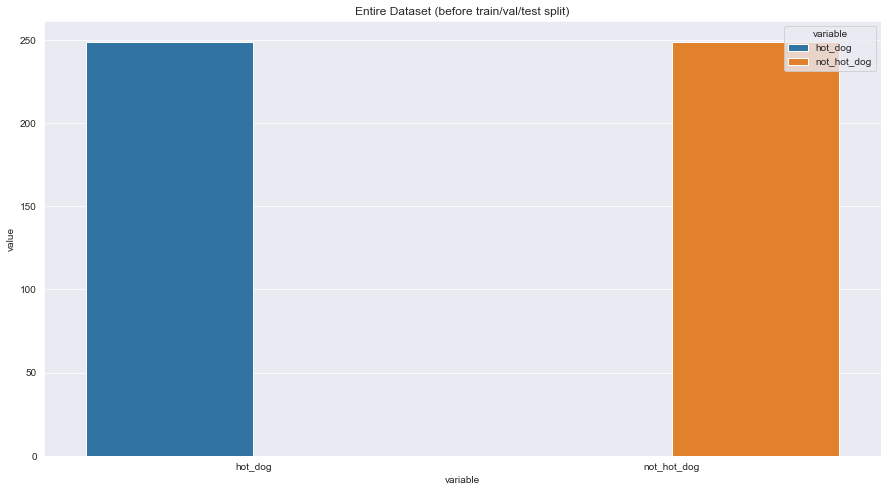

In [14]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(hotdog_dataset), plot_title="Entire Dataset (before train/val/test split)")

In [15]:
hotdog_dataset_size = len(hotdog_dataset)
hotdog_dataset_indices = list(range(hotdog_dataset_size))

In [16]:
np.random.shuffle(hotdog_dataset_indices)

In [17]:
val_split_index = int(np.floor(0.2 * hotdog_dataset_size))

In [18]:
train_idx, val_idx = hotdog_dataset_indices[val_split_index:], hotdog_dataset_indices[:val_split_index]

In [19]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [20]:
hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"]
                                           )
hotdog_dataset_test

Dataset ImageFolder
    Number of datapoints: 500
    Root location: D:/Dataset-pytorch/seefood/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [21]:
train_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=False, batch_size=1)

In [22]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

Text(0.5, 1.0, 'Val Set')

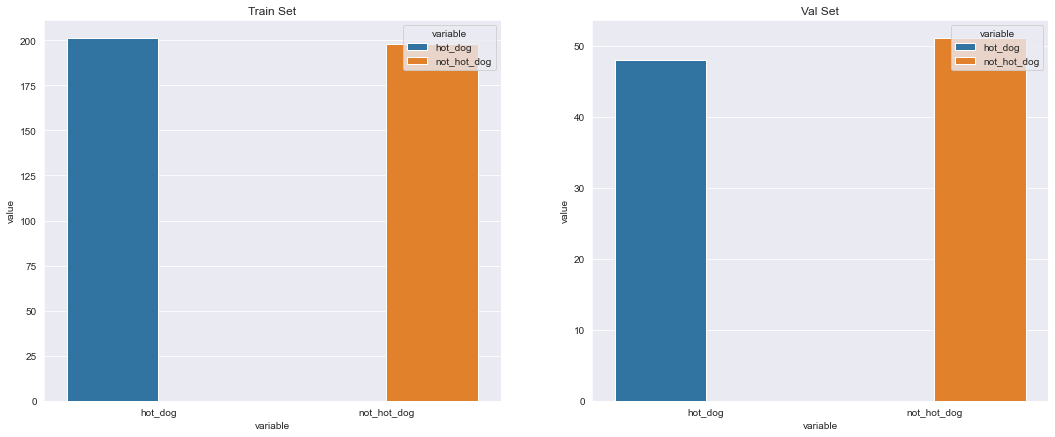

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, hotdog_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, hotdog_dataset), plot_title="Val Set", ax=axes[1])

In [24]:
single_batch = next(iter(train_loader))

In [25]:
single_batch[0].shape

torch.Size([8, 3, 224, 224])

In [26]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([1, 1, 1, 1, 1, 1, 1, 1])

Output label tensor shape:  torch.Size([8])


In [28]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

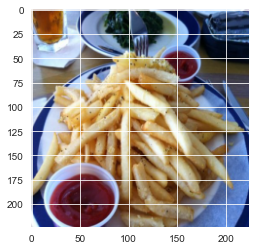

In [29]:
plt.imshow(single_image.permute(1, 2, 0))

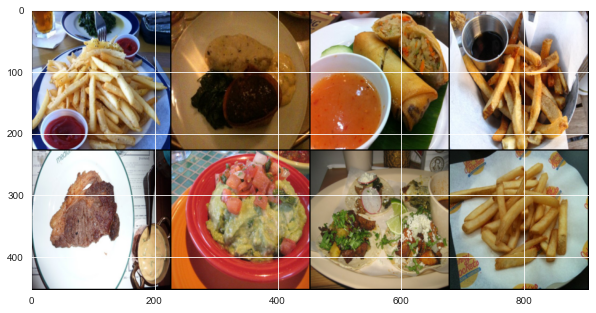

In [30]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [31]:
class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [32]:
model = HotDogClassifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

HotDogClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [33]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [34]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [35]:
print("Begin training.")
for e in tqdm(range(1, 21)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 01: | Train Loss: 117.63292 | Val Loss: 102.63390 | Train Acc: 55.100| Val Acc: 71.000
Epoch 02: | Train Loss: 49.96766 | Val Loss: 56.39574 | Train Acc: 61.800| Val Acc: 43.000
Epoch 03: | Train Loss: 23.68704 | Val Loss: 18.88808 | Train Acc: 69.220| Val Acc: 71.000
Epoch 04: | Train Loss: 16.00783 | Val Loss: 4.84564 | Train Acc: 73.760| Val Acc: 86.000
Epoch 05: | Train Loss: 10.07102 | Val Loss: 15.17371 | Train Acc: 76.780| Val Acc: 71.000
Epoch 06: | Train Loss: 6.83694 | Val Loss: 0.00000 | Train Acc: 82.800| Val Acc: 100.000
Epoch 07: | Train Loss: 5.61763 | Val Loss: 8.34919 | Train Acc: 78.940| Val Acc: 71.000
Epoch 08: | Train Loss: 4.00280 | Val Loss: 8.66698 | Train Acc: 85.820| Val Acc: 71.000
Epoch 09: | Train Loss: 1.96935 | Val Loss: 2.80714 | Train Acc: 87.480| Val Acc: 86.000
Epoch 10: | Train Loss: 1.05448 | Val Loss: 0.00249 | Train Acc: 92.440| Val Acc: 100.000
Epoch 11: | Train Loss: 0.70525 | Val Loss: 1.37057 | Train Acc: 94.840| Val Acc: 86.000
Epoch 12

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

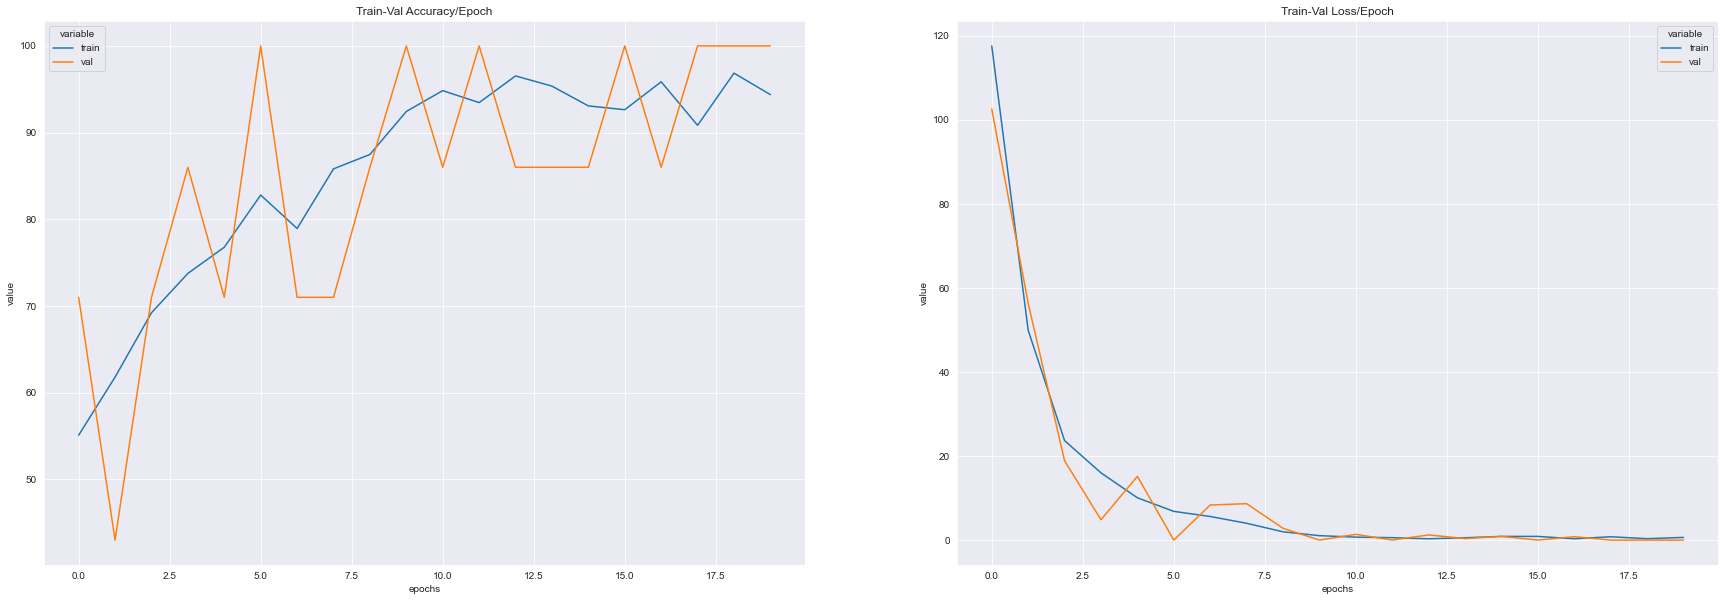

In [36]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [37]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [38]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [39]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.61      0.36      0.45       250
           1       0.55      0.77      0.64       250

    accuracy                           0.57       500
   macro avg       0.58      0.57      0.55       500
weighted avg       0.58      0.57      0.55       500



In [40]:
print(confusion_matrix(y_true_list, y_pred_list))

[[ 90 160]
 [ 57 193]]


<AxesSubplot:>

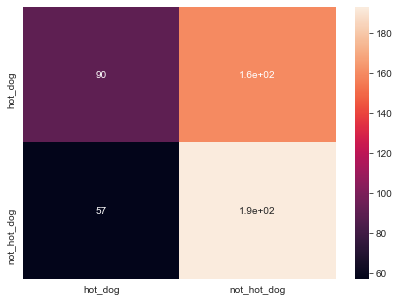

In [41]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)